In [1]:
import os
import glob
import numpy as np
from obspy import Stream, Trace, UTCDateTime
import seisbench.models as sbm
import csv
from model2 import UNet2D
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
# === パラメータ ===
SAMPLE_RATE = 100
WIN_LENGTH = 30
HOP_LENGTH = 15
N_FFT = 60
DURATION = 30 * SAMPLE_RATE
EPS = 1e-8

def calculate_istft(spec_tensor):
    # Build complex spectrogram
    complex_spec = spec_tensor[:, 0] + 1j * spec_tensor[:, 1]
    # Hann window on correct device
    window = torch.hann_window(WIN_LENGTH, device=complex_spec.device)
    # Inverse STFT
    wave = (WIN_LENGTH/2) * torch.istft(
        complex_spec,
        n_fft=N_FFT,
        win_length=WIN_LENGTH,
        hop_length=HOP_LENGTH,
        window=window,
        normalized=False,
        length=DURATION
    )
    return wave


def normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    if std.item() == 0:
        std = torch.tensor(1.0, device=tensor.device)
    return (tensor - mean) / std

def compute_stft_with_phase_rotation(wave):
    stft = torch.stft(
        torch.from_numpy(wave),
        n_fft=N_FFT,
        return_complex=True,
        win_length=WIN_LENGTH,
        hop_length=HOP_LENGTH,
        window=torch.hann_window(WIN_LENGTH),
        pad_mode="constant",
        normalized=False,
    )

    stft = (2 / WIN_LENGTH) * stft

    return stft

def process_wave(wave):
    stft = compute_stft_with_phase_rotation(wave)
    stft_real_img = torch.stack([stft.real, stft.imag], dim=0)  # shape: [2, F, T]
    return stft_real_img


# === モデル読み込み ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet2D()
model = model.to(device)
model.load_state_dict(torch.load("unet_snr/model/best_model.pt", map_location=device))
model.eval()


def denoise(model, deepdenoiser, original_stream):
    """
    model         : UNet マスク予測モデル
    deepdenoiser  : 事前学習済み DeepDenoiser オブジェクト
    original_stream: 入力ストリーム
    戻り値:
      denoised_waves: ndarray (3, N)
      orig_abs       : ndarray (3, F, T)
      denoised_abs   : ndarray (3, F, T)
      deepdenoised_wave, deepdenoised_abs (DeepDenoiser出力)
    """
    # 1) DeepDenoiser 処理
    deepdenoised_stream = deepdenoiser.annotate(original_stream)
    deepdenoised_wave = convert_stream_to_ndarray(
        deepdenoised_stream,
        channel_order=["DeepDenoiser_UD", "DeepDenoiser_NS", "DeepDenoiser_EW"]
    )
    deepdenoised_abs = []
    for i in range(3):
        deepdenoised_stft = process_wave(deepdenoised_wave[i])
        d_abs = torch.abs(
            deepdenoised_stft[0] + deepdenoised_stft[1] * 1j
        ).cpu().numpy()
        deepdenoised_abs.append(d_abs)

    # 2) オリジナルストリームを numpy に変換
    original = convert_stream_to_ndarray(original_stream)  # shape: [3, N]

    orig_abs = []
    denoised_abs = []
    denoised_wave_list = []
    pred_mask_list = []

    for i in range(original.shape[0]):
        # スペクトログラム取得 (torch.Tensor: [2, F, T])
        real, imag = process_wave(original[i].astype(np.float32))

        # 正規化
        real_n = normalize(real)
        imag_n = normalize(imag)
        spec_norm = torch.stack([real_n, imag_n], dim=0).unsqueeze(0).to(device)  # [1,2,F,T]

        # 予測マスク取得
        with torch.no_grad():
            pred = model(spec_norm)                # [1,1,F,T]
        pred_mask = pred.squeeze(0)                 # [1,F,T]
        pred_mask_list.append(pred_mask.squeeze(0).cpu().numpy())
        # オリジナルスペクトログラムにマスクを適用
        orig_spec = torch.stack([real, imag], dim=0).unsqueeze(0).to(device)  # [1,2,F,T]
        masked_spec = orig_spec * pred_mask.unsqueeze(1)

        # ISTFT による逆変換
        denoised_wave = calculate_istft(masked_spec)  # [1, L]
        denoised_wave = denoised_wave.squeeze(0).cpu().numpy()
        denoised_wave_list.append(denoised_wave)

        # 振幅スペクトログラム
        abs_orig = torch.abs(real + 1j * imag).cpu().numpy()
        masked_spec_array = masked_spec.squeeze(0).cpu().numpy()
        abs_denoised = np.abs(
            masked_spec_array[0] + masked_spec_array[1] * 1j
        )

        orig_abs.append(abs_orig)
        denoised_abs.append(abs_denoised)

    return (
        np.stack(denoised_wave_list, axis=0),
        np.stack(orig_abs, axis=0),
        np.stack(denoised_abs, axis=0),
        deepdenoised_wave,
        deepdenoised_abs,
        np.stack(pred_mask_list, axis=0)
    )


# Utility functions
def convert_ndarry_stream(data, time_str, station_name, sampling_rate=100):
    """
    Convert a 2D NumPy array of waveform data into an ObsPy Stream object.

    Parameters
    ----------
    data : np.ndarray
        2D array of shape (3, N), where N is the number of samples for each component (UD, NS, EW).
    time_str : str
        Start time string in the format 'yymmdd_HHMMSS' (e.g., '150323_141948').
    station_name : str
        Station name to be assigned to each trace.
    sampling_rate : float, optional
        Sampling rate in Hz. Default is 100 Hz.

    Returns
    -------
    stream : obspy.Stream
        ObsPy Stream object containing three Traces with appropriate metadata.
    """
    year = 2000 + int(time_str[:2])
    month, day = int(time_str[2:4]), int(time_str[4:6])
    hour, minute, second = int(time_str[7:9]), int(time_str[9:11]), int(time_str[11:13])
    utc_time = UTCDateTime(year, month, day, hour, minute, second)

    channels = ["UD", "NS", "EW"]
    stream = Stream()
    for i, ch in enumerate(channels):
        trace = Trace(data=data[i, :])
        trace.stats.update({
            "sampling_rate": sampling_rate,
            "starttime": utc_time,
            "network": "MeSO-net",
            "station": station_name,
            "location": "",
            "channel": ch,
        })
        stream.append(trace)
    return stream

def convert_stream_to_ndarray(stream, channel_order=["UD", "NS", "EW"]):
    """
    Convert ObsPy Stream to ndarray of shape (samples, channels).

    Parameters:
        stream (obspy.Stream): Stream object containing 3 components.
        channel_order (list): Order of channels to extract, default is ["UD", "NS", "EW"].

    Returns:
        np.ndarray: Array of shape (3, n_samples)
    """
    traces = []
    for ch in channel_order:
        tr = stream.select(channel=ch)
        if len(tr) == 0:
            raise ValueError(f"Channel {ch} not found in the stream.")
        traces.append(tr[0].data)

    # Stack and transpose to shape (samples, channels)
    data = np.stack(traces)
    return data

def calc_snr(signal, noise):
    """
    Calculate signal-to-noise ratio (SNR) in decibels (dB).

    Parameters:
    ----------
    signal : np.ndarray
        Array containing the signal portion.
    noise : np.ndarray
        Array containing the noise portion.

    Returns:
    -------
    float
        SNR value in dB.
    """
    return 10 * np.log10(np.std(signal) / np.std(noise))

def calc_cc(a, b):
    """
    Calculate the Pearson correlation coefficient between two signals.

    Parameters:
    ----------
    a : np.ndarray
        First signal.
    b : np.ndarray
        Second signal.

    Returns:
    -------
    float
        Correlation coefficient between a and b (range: -1 to 1).
    """
    return np.corrcoef(a, b)[0, 1]

def zscore(data):
    """
    Normalize each channel using z-score normalization (zero mean, unit variance).

    Parameters:
    ----------
    data : np.ndarray
        2D array of shape (channels, time), e.g., (3, N).

    Returns:
    -------
    np.ndarray
        Z-score normalized data with the same shape.
    """
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    normalized_data = (data - mean) / std
    return normalized_data

def calc_loss(data1, data2, p_onset, s_onset, sf=100):

    '''
    Calculate a loss value based on signal-to-noise ratio (SNR) and correlation coefficients (CC)
    between original and denoised seismic waveform data for P-wave, S-wave, and noise segments.

    Parameters:
    ----------
    data1 (Original wave) : np.ndarray
        Original waveform data of shape (3, N), where N is the number of time steps.
    data2 (Denoised wave) : np.ndarray
        Denoised waveform data of shape (3, N), corresponding to data1.

    Returns:
    -------
    loss : float
        Averaged loss across 3 channels, combining SNR and CC values.
    P_SNR : float
        Averaged P-wave SNR after denoising.
    S_SNR : float
        Averaged S-wave SNR after denoising.
    P_CC : float
        Averaged correlation coefficient between original and denoised P-wave signals.
    s_cc : float
        Averaged correlation coefficient between original and denoised S-wave signals.
    n_cc : float
        Averaged correlation coefficient between original and denoised noise segments.
    '''

    p_snrs = []
    s_snrs = []
    p_ccs = []
    s_ccs = []
    n_ccs = []

    loss = []

    for ch in [0,1,2]:
        orig_data = data1[ch,:]
        den_data = data2[ch,:]

        signal_p = orig_data[p_onset : p_onset+sf*5]
        noise_p = orig_data[p_onset-sf*5 : p_onset]

        signal_p_deno = den_data[p_onset : p_onset+sf*5]
        noise_p_deno = den_data[p_onset-sf*5 : p_onset]

        signal_s = orig_data[s_onset : s_onset+sf*5]
        signal_s_deno = den_data[s_onset : s_onset+sf*5]

        snr_p_orig = calc_snr(signal_p, noise_p)
        snr_s_orig = calc_snr(signal_s, noise_p)

        snr_p_deno = calc_snr(signal_p_deno, noise_p_deno)
        snr_s_deno = calc_snr(signal_s_deno, noise_p_deno)

        cc_n = calc_cc(noise_p, noise_p_deno)
        cc_p = calc_cc(signal_p, signal_p_deno)
        cc_s = calc_cc(signal_s, signal_s_deno)

        loss_ch = (snr_p_deno + snr_s_deno) * cc_p * cc_s * cc_n

        p_snrs.append(snr_p_deno)
        s_snrs.append(snr_s_deno)

        p_ccs.append(cc_p)
        s_ccs.append(cc_s)
        n_ccs.append(cc_n)

        loss.append(loss_ch)

    return np.mean(loss), p_snrs, s_snrs, p_ccs, s_ccs, n_ccs

In [3]:
# Load pretrained denoising model
deepdenoiser = sbm.DeepDenoiser.from_pretrained("original")


model_type = "CBAM"
total_loss = 0

# Prepare data
files = sorted(glob.glob('data/Test/*'))     # 適切なパスを設定
reports_dir = Path("unet_snr/reports/")
reports_dir.mkdir(parents=True, exist_ok=True)

print(len(files))

with open(reports_dir / f'{model_type}_loss_results.csv', 'w', newline='') as csvfile:   # 適切なパスを設定
    writer = csv.writer(csvfile)

    # headder
    writer.writerow(['FileName', 'LOSS', 'UD_P_SNR', 'UD_S_SNR', 'UD_P_CC', 'UD_S_CC', 'UD_N_CC', 'NS_P_SNR', 'NS_S_SNR', 'NS_P_CC', 'NS_S_CC', 'NS_N_CC', 'EW_P_SNR', 'EW_S_SNR', 'EW_P_CC', 'EW_S_CC', 'EW_N_CC'])

    for num, fn in tqdm(enumerate(files), total=len(files)):
      data = np.load(fn)
      wave, pidx, sidx = data['wave'], data['pidx'], data['sidx']
      time_str, station_name = os.path.basename(fn).replace('.npz', '').split('_')

      # Create ObsPy Stream
      original_stream = convert_ndarry_stream(wave-np.mean(wave, axis=1, keepdims=True), time_str, station_name)

      denoised_wave, orig_abs, denoised_abs, deepdenoised_wave, deepdenoised_abs, pred_mask_array = denoise(model, deepdenoiser, original_stream)
      orig_wave = convert_stream_to_ndarray(original_stream, channel_order=["UD", "NS", "EW"])

      if model_type == "deepdenoiser":
          denoised_wave = deepdenoised_wave
      elif (model_type == "CBAM") and (num <= 5):
          titles = ["UD", "NS", "EW"]
          fig, axes = plt.subplots(5, 3, figsize=(20, 15))

          for i in range(3):
            axes[0, i].set_title(f"Original waveform {titles[i]}")
            axes[0, i].plot(np.linspace(0, 30, 30*100), orig_wave[i], c="k", lw=0.5)
            axes[0, i].vlines(
                pidx/100,
                np.min(orig_wave[i]), 
                np.max(orig_wave[i]), 
                color="r", 
                lw=1
            )
            axes[0, i].vlines(
                sidx/100,
                np.min(orig_wave[i]), 
                np.max(orig_wave[i]), 
                color="b", 
                lw=1
            )
            axes[0, i].set_xlim(0, 30)
            axes[1, i].set_title(f"Original Spectrogram [log10] {titles[i]}")
            axes[1, i].imshow(
                np.log10(orig_abs[i]+1e-8), 
                extent=[0, 30, 0, 50], 
                origin="lower", 
                aspect="auto"
            )
            axes[2, i].set_title(f"Predicted Mask {titles[i]}")
            axes[2, i].imshow(
                pred_mask_array[i],
                extent=[0, 30, 0, 50], 
                origin="lower", 
                aspect="auto"
            )
            axes[3, i].set_title(f"Denoised waveform {titles[i]}")
            axes[3, i].vlines(
                pidx/100,
                np.min(denoised_wave[i]), 
                np.max(denoised_wave[i]), 
                color="r", 
                lw=1
            )
            axes[3, i].vlines(
                sidx/100,
                np.min(denoised_wave[i]), 
                np.max(denoised_wave[i]), 
                color="b", 
                lw=1
            )
            axes[3, i].plot(np.linspace(0, 30, 30*100), denoised_wave[i], c="k", lw=0.5)
            axes[3, i].set_xlim(0, 30)
            axes[4, i].set_title(f"Denoised Spectrogram [log10] {titles[i]}")
            axes[4, i].imshow(
                np.log10(denoised_abs[i] + 1e-8), 
                extent=[0, 30, 0, 50], 
                origin="lower", 
                aspect="auto"
            )
            axes[4, i].set_xlabel("Time [s]")


          # 縦の間隔を広げる
          plt.subplots_adjust(hspace=0.4)

          # ファイル名を動的に生成して保存
          fig_name = reports_dir / f"figures/{os.path.basename(fn).replace('.npz', '')}_comparison.png"
          os.makedirs(reports_dir / "figures", exist_ok=True)
          plt.savefig(fig_name, dpi=300, bbox_inches='tight')
          plt.close()

      loss, p_snrs, s_snrs, p_ccs, s_ccs, n_ccs = calc_loss(orig_wave, denoised_wave, pidx, sidx)

      writer.writerow([os.path.basename(fn),
                       loss,
                       p_snrs[0], s_snrs[0], p_ccs[0], s_ccs[0], n_ccs[0],
                       p_snrs[1], s_snrs[1], p_ccs[1], s_ccs[1], n_ccs[1],
                       p_snrs[2], s_snrs[2], p_ccs[2], s_ccs[2], n_ccs[2]])

      # print(os.path.basename(fn), loss, p_snr, s_snr, P_CC, s_cc, n_cc)

      total_loss += loss

print(f'Total Loss = {total_loss/(len(files))}')


500


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:17<00:00, 28.60it/s]

Total Loss = 165.8824346227415


In [25]:
import pandas as pd

df = pd.read_csv("unet_snr/reports/CBAM_loss_results.csv")
df.describe()

,LOSS,UD_P_SNR,UD_S_SNR,UD_P_CC,UD_S_CC,UD_N_CC,NS_P_SNR,NS_S_SNR,NS_P_CC,NS_S_CC,NS_N_CC,EW_P_SNR,EW_S_SNR,EW_P_CC,EW_S_CC,EW_N_CC
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,165.880843,90.198160,91.055034,0.936345,0.974447,0.894092,93.444124,100.026578,0.903614,0.981561,0.958591,91.697339,97.740864,0.915502,0.980684,0.935901
std,49.713671,30.667986,30.184512,0.066523,0.042786,0.270784,24.535924,20.973525,0.140946,0.032155,0.181751,26.662820,23.583486,0.114837,0.029159,0.228130
min,-2.630947,-0.166306,-5.822994,0.404766,0.349395,-0.084861,-1.550809,1.078710,-0.023907,0.613287,-0.071252,-3.247243,1.088342,0.030465,0.779175,-0.081132
25%,144.429804,97.114425,96.922441,0.910709,0.967201,0.996165,95.171897,100.301638,0.884039,0.979816,0.999279,94.709640,99.821002,0.887562,0.975923,0.999237
50%,180.428764,100.932226,101.326237,0.953471,0.989808,0.999117,99.586463,103.814750,0.946187,0.994054,0.999652,99.583778,103.145742,0.951234,0.992687,0.999654
75%,201.697957,105.289958,105.534451,0.984496,0.997008,0.999613,103.507113,107.699382,0.986192,0.997474,0.999782,103.378379,107.235332,0.983953,0.997229,0.999791
max,242.465249,118.737030,122.387600,0.999701,0.999828,0.999914,122.442465,125.883303,0.999863,0.999780,0.999948,119.189959,124.363909,0.999866,0.999601,0.999937


In [29]:
# 必要な列が確認できたので、平均を算出
summary_data = []

# SNRとCCの列をそれぞれ分類
snr_cols = [col for col in df.columns if "_SNR" in col]
cc_cols = [col for col in df.columns if "_CC" in col]

# SNR: 各成分（UD, NS, EW）のP, Sごと
for col in snr_cols:
    component, phase, _ = col.split("_")
    mean_val = df[col].mean()
    summary_data.append({
        "Metric": "SNR",
        "Component": component,
        "Phase": phase,
        "Mean": mean_val
    })

# CC: 各成分（UD, NS, EW）のP, S, Nごと
for col in cc_cols:
    component, phase, _ = col.split("_")
    mean_val = df[col].mean()
    summary_data.append({
        "Metric": "CC",
        "Component": component,
        "Phase": phase,
        "Mean": mean_val
    })

summary_df = pd.DataFrame(summary_data)
summary_df


,Metric,Component,Phase,Mean
0,SNR,UD,P,90.198160
1,SNR,UD,S,91.055034
2,SNR,NS,P,93.444124
3,SNR,NS,S,100.026578
4,SNR,EW,P,91.697339
5,SNR,EW,S,97.740864
6,CC,UD,P,0.936345
7,CC,UD,S,0.974447
8,CC,UD,N,0.894092
9,CC,NS,P,0.903614


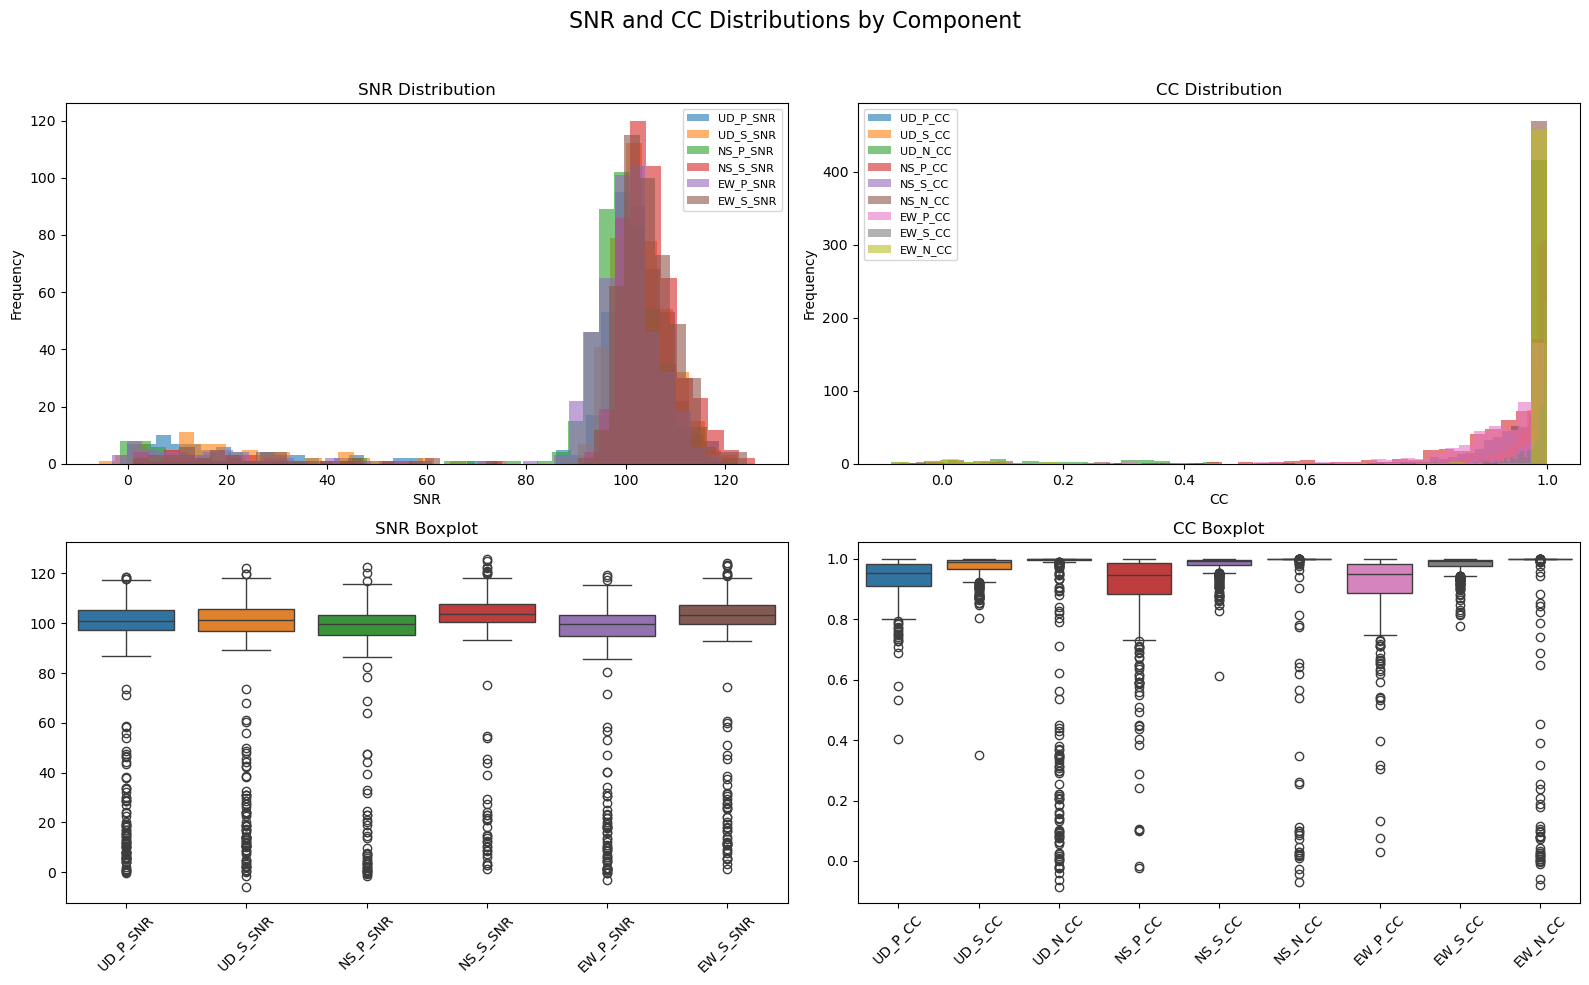

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# SNRとCCに関する列を再度定義
snr_cols = [col for col in df.columns if "_SNR" in col]
cc_cols = [col for col in df.columns if "_CC" in col]

# プロットスタイル
# plt.style.use("seaborn-whitegrid")

# 図の作成
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("SNR and CC Distributions by Component", fontsize=16)

# 上段: ヒストグラム
for col in snr_cols:
    axes[0, 0].hist(df[col], bins=40, alpha=0.6, label=col)
axes[0, 0].set_title("SNR Distribution")
axes[0, 0].set_xlabel("SNR")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend(fontsize=8)

for col in cc_cols:
    axes[0, 1].hist(df[col], bins=40, alpha=0.6, label=col)
axes[0, 1].set_title("CC Distribution")
axes[0, 1].set_xlabel("CC")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend(fontsize=8)

# 下段: 箱ひげ図
sns.boxplot(data=df[snr_cols], ax=axes[1, 0])
axes[1, 0].set_title("SNR Boxplot")
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df[cc_cols], ax=axes[1, 1])
axes[1, 1].set_title("CC Boxplot")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
